In [ ]:
import pandas as pd
import os
import glob

def load_all_homes(datalake_path):
    """
    Carga y concatena todos los archivos homes.tsv de los distintos años desde el datalake.
    Añade una columna 'Año' a cada archivo basado en el nombre del directorio.
    Solo conserva las columnas necesarias: 'NUMERO', 'IMPEXAC' y 'Año'.
    """
    homes_files = glob.glob(os.path.join(datalake_path, "*", "homes.tsv"))
    df_list = []

    for file in homes_files:
        year = os.path.basename(os.path.dirname(file))  # Extraer año de la carpeta
        df = pd.read_csv(file, sep="\t")

        if "NUMERO" in df.columns and "IMPEXAC" in df.columns:
            df = df[["NUMERO", "IMPEXAC"]]  # Filtrar columnas necesarias
            df["Año"] = int(year)
            df_list.append(df)

    if not df_list:
        raise FileNotFoundError("No se encontraron archivos homes.tsv en el datalake o no contienen columnas requeridas.")

    df_homes = pd.concat(df_list, ignore_index=True)
    return df_homes

def merge_homes_with_datamart(df_homes, datamart_path):
    """
    Une el DataFrame de homes con el datamart por las columnas 'Año' y 'NUMERO'.
    """
    df_datamart = pd.read_csv(datamart_path, sep="\t")
    df_merged = pd.merge(df_datamart, df_homes, on=["Año", "NUMERO"], how="inner")
    return df_merged

# Uso
datalake_path = "DataLake/"
datamart_path = "datamarts/datamart_supercategories_three_digits.tsv"
datamart_path2 = "datamarts/datamart_supercategories.tsv"


# Cargar y unir
df_homes = load_all_homes(datalake_path)
df_merged = merge_homes_with_datamart(df_homes, datamart_path)

df_merged2 = merge_homes_with_datamart(df_homes, datamart_path2)


In [33]:
pd.set_option("display.max_columns", None)
df_merged.head()

,Año,NUMERO,SUPER_CATEGORIA,GASTO_MENSUAL,IMPEXAC
0,2016,1,11,88.636140,1225
1,2016,1,12,0.076308,1225
2,2016,1,22,2.970634,1225
3,2016,1,31,18.523350,1225
4,2016,1,42,376.175600,1225


In [34]:
df_merged = df_merged[["Año", "SUPER_CATEGORIA", "GASTO_MENSUAL", "IMPEXAC"]]
df_merged.tail(10)

,Año,SUPER_CATEGORIA,GASTO_MENSUAL,IMPEXAC
3326213,2023,82,75.202500,4463
3326214,2023,83,79.999999,4463
3326215,2023,94,3.293608,4463
3326216,2023,95,7.585717,4463
3326217,2023,96,169.708825,4463
3326218,2023,111,883.955361,4463
3326219,2023,121,65.902959,4463
3326220,2023,125,62.083333,4463
3326221,2023,126,7.298728,4463
3326222,2023,127,127.727742,4463


In [47]:
import pandas as pd

def agregar_por_rangos_impexac(df, bins=None):
    """
    Agrupa el porcentaje de gasto por rangos de ingresos (IMPEXAC) y SUPER_CATEGORIA.
    Devuelve la media del GASTO_MENSUAL por grupo.
    """
    if bins is None:
        # Definir bins personalizados adecuados a tus datos
        max_val = df["IMPEXAC"].max()
        bins = [0.00001, 920, 1500, 2000, 2500, 3500, 5000, 8000,  max_val]

    df["IMPEXAC_RANGO"] = pd.cut(df["IMPEXAC"], bins=bins, include_lowest=True)

    # Agrupar por rango + categoría
    resultado = (
        df.groupby(["IMPEXAC_RANGO", "SUPER_CATEGORIA"])["GASTO_MENSUAL"]
        .mean()
        .reset_index()
    )

    return resultado

df_agg = agregar_por_rangos_impexac(df_merged)
df_agg2 = agregar_por_rangos_impexac(df_merged2)

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

def graficar_gasto_por_super_categoria(df_agg):
    """
    Genera un gráfico de barras por SUPER_CATEGORIA con el gasto mensual promedio por rango de IMPEXAC.
    Las barras estarán pegadas entre sí.
    """
    categorias = df_agg["SUPER_CATEGORIA"].unique()
    n = len(categorias)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(10, 5 * n))

    if n == 1:
        axes = [axes]

    for i, cat in enumerate(categorias):
        df_cat = df_agg[df_agg["SUPER_CATEGORIA"] == cat]
        bar = sns.barplot(
            data=df_cat,
            x="IMPEXAC_RANGO",
            y="GASTO_MENSUAL",
            hue="IMPEXAC_RANGO",
            palette="Blues_d",
            ax=axes[i],
            legend=False
        )
        
        # Ajustamos el ancho de las barras (pegadas)
        for container in bar.containers:
            for bar_rect in container:
                bar_rect.set_width(1.0)  # Ancho completo
                bar_rect.set_x(bar_rect.get_x() - 0.5)  # Centrar

        axes[i].set_title(f"Gasto mensual por rango de IMPEXAC - Categoría {cat}")
        axes[i].set_xlabel("Rango de IMPEXAC")
        axes[i].set_ylabel("Gasto mensual (€)")
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


### Por super categoría con dos dígitos

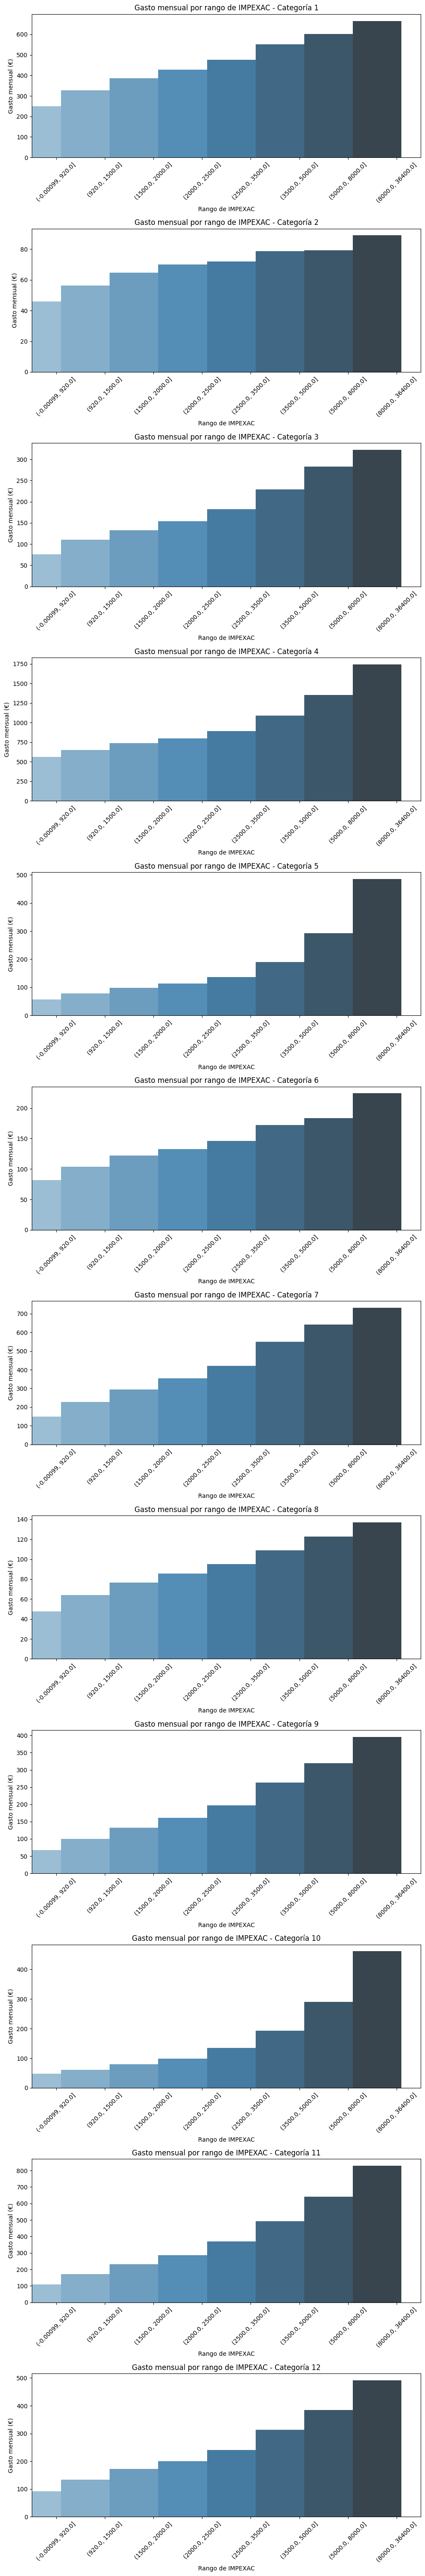

In [49]:
graficar_gasto_por_super_categoria(df_agg2)

### Por super categoría con tres dígitos

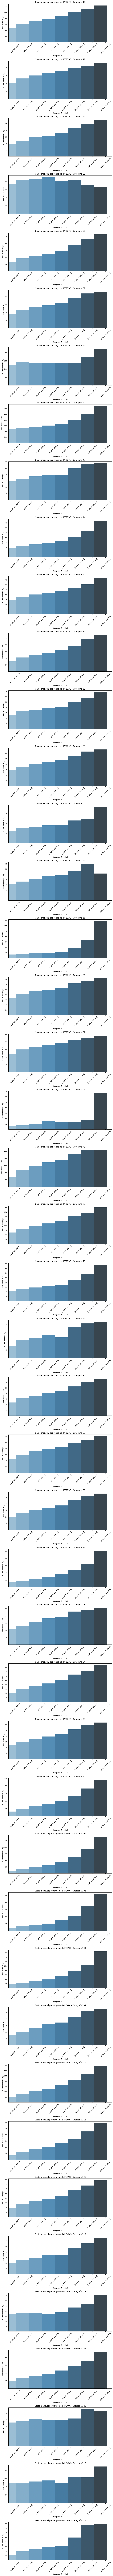

In [37]:
graficar_gasto_por_super_categoria(df_agg)


## Porcentaje de ingresos por supercategoría

In [38]:
import pandas as pd

df = pd.read_csv("datamarts/porcentaje_gasto_supercategorias.tsv", sep="\t")

In [39]:
df.head(5)

,Año,NUMERO,SUPER_CATEGORIA,porcentaje_gasto,IMPEXAC
0,2016,1,1,5.55,1225
1,2016,1,2,0.19,1225
2,2016,1,3,1.16,1225
3,2016,1,4,28.52,1225
4,2016,1,5,0.28,1225


In [40]:
import pandas as pd

def agregar_por_rangos_impexac_2(df, bins=None):
    """
    Agrupa el porcentaje de gasto por rangos de ingresos (IMPEXAC) y SUPER_CATEGORIA.
    Devuelve la media del porcentaje_gasto por grupo.
    """
    if bins is None:
        # Definir bins personalizados adecuados a tus datos
        max_val = df["IMPEXAC"].max()
        bins = [0.00001, 920, 1500, 2000, 2500, 3500, 5000, 8000,  max_val]

    df["IMPEXAC_RANGO"] = pd.cut(df["IMPEXAC"], bins=bins, include_lowest=True)

    # Agrupar por rango + categoría
    resultado = (
        df.groupby(["IMPEXAC_RANGO", "SUPER_CATEGORIA"])["porcentaje_gasto"]
        .mean()
        .reset_index()
        .rename(columns={"porcentaje_gasto": "porcentaje_gasto_medio"})
    )

    return resultado


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

def graficar_gasto_por_super_categoria(df_agg):
    """
    Genera un gráfico de barras por SUPER_CATEGORIA con el gasto mensual promedio por rango de IMPEXAC.
    Las barras estarán pegadas entre sí.
    """
    categorias = df_agg["SUPER_CATEGORIA"].unique()
    n = len(categorias)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(10, 5 * n))

    if n == 1:
        axes = [axes]

    for i, cat in enumerate(categorias):
        df_cat = df_agg[df_agg["SUPER_CATEGORIA"] == cat]
        bar = sns.barplot(
            data=df_cat,
            x="IMPEXAC_RANGO",
            y="porcentaje_gasto_medio",
            hue="IMPEXAC_RANGO",
            palette="Blues_d",
            ax=axes[i],
            legend=False
        )
        
        # Ajustamos el ancho de las barras (pegadas)
        for container in bar.containers:
            for bar_rect in container:
                bar_rect.set_width(1.0)  # Ancho completo
                bar_rect.set_x(bar_rect.get_x() - 0.5)  # Centrar

        axes[i].set_title(f"Porcentaje de gasto por rango de IMPEXAC - Categoría {cat}")
        axes[i].set_xlabel("Rango de IMPEXAC")
        axes[i].set_ylabel("Porcentaje de gasto (%)")
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


In [42]:
df_agg = agregar_por_rangos_impexac_2(df)
df_agg.head(5)

,IMPEXAC_RANGO,SUPER_CATEGORIA,porcentaje_gasto_medio
0,"(-0.00099, 920.0]",1,19.820160
1,"(-0.00099, 920.0]",2,3.529976
2,"(-0.00099, 920.0]",3,5.277001
3,"(-0.00099, 920.0]",4,47.313058
4,"(-0.00099, 920.0]",5,4.075120


In [43]:
df_agg['IMPEXAC_RANGO'].value_counts()

(-0.00099, 920.0]    12
(920.0, 1500.0]      12
(1500.0, 2000.0]     12
(2000.0, 2500.0]     12
(2500.0, 3500.0]     12
(3500.0, 5000.0]     12
(5000.0, 8000.0]     12
(8000.0, 36400.0]    12
Name: IMPEXAC_RANGO, dtype: int64

In [44]:
print(df[df["IMPEXAC"] <= 1000]["SUPER_CATEGORIA"].value_counts())


4     27560
1     26866
12    26578
8     24642
5     24470
7     16713
9     15481
3     15434
6     15290
2     14355
11    14302
10     3193
Name: SUPER_CATEGORIA, dtype: int64


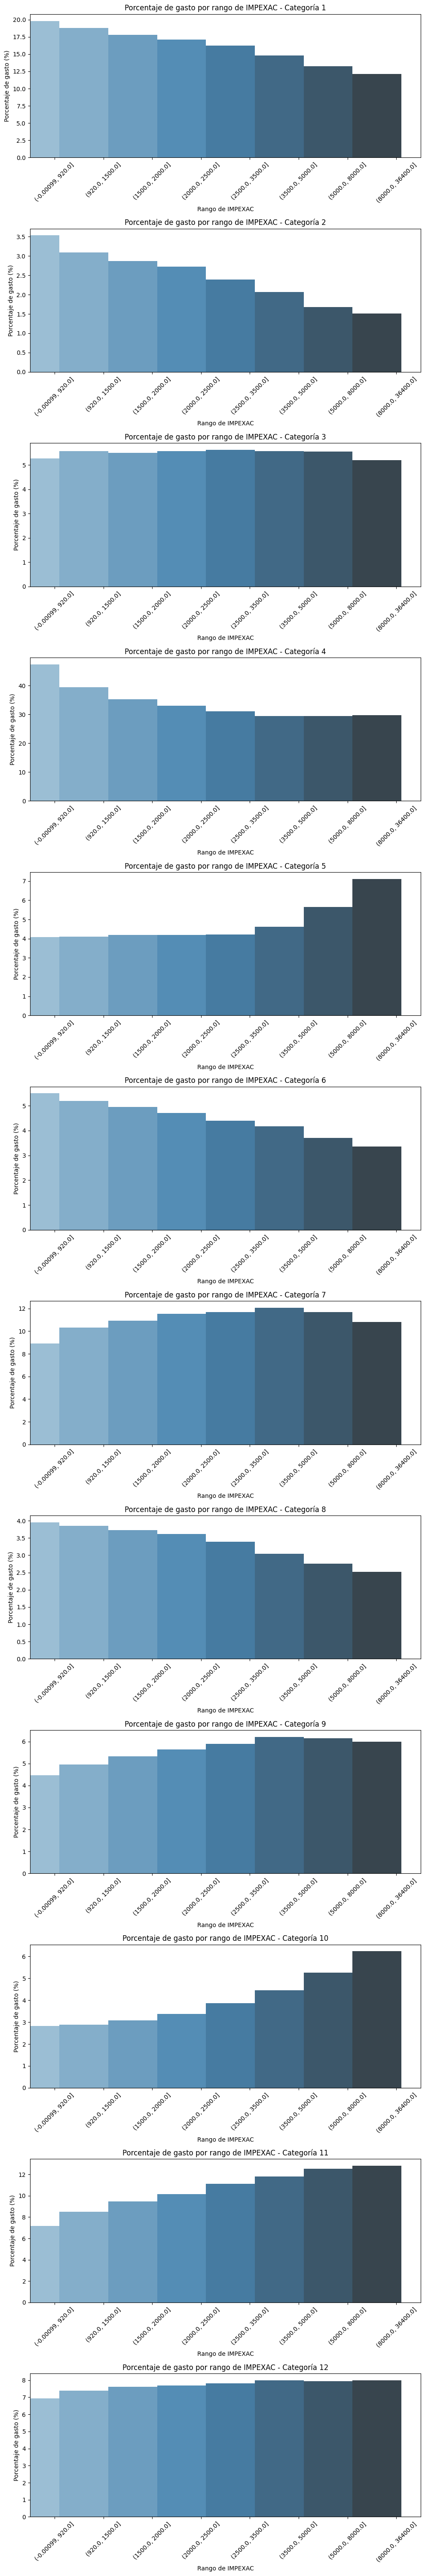

In [45]:
graficar_gasto_por_super_categoria(df_agg)